# Feature Selection con EDA
## David Omar Paredes Paredes
## Abraham Maximiliano Ávalos Corrales

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_absolute_error


In [2]:
pop = np.array(
	[[0, 1, 1, 0]
	,[0, 1, 0, 1]
	,[1, 1, 1, 1]
	,[0, 1, 1, 0]
	]
)

prob = np.count_nonzero(pop, axis=0) / len(pop[0])
print(prob)

[0.25 1.   0.75 0.5 ]


### Clases de utilidad

In [3]:
class Problem:
	def generate_initial_population(self, p_size) -> list:...
	def _compare(self, fitness_a, fitness_b) -> int:...

	def get_parent(self, parent_F:list) -> int:...
	def mix_parents(self, parent_a, parent_b, ratio:float=0.5):...
	def mutate(self, g):...
	def check_individual_integrity(self, g) -> bool: return True
		
	def get_prob_dist(self, E:list):...
	def generate_from_prob_dist(self, Pd:list, n_p:int) -> list:...

	def get_fitness(self, G:list, F:list=None):...
	def get_elite(self, G:list, F:list) -> (list, list):...
	def arg_get_elite(self, G:list, F:list, n:int=1):...
	def deep_copy(self, G, population:bool=True):...
	def update_elite(self, E, newE, Fe, newFe):...

	def solved(self, Fe:list): return False
	def has_progress_metric(self) -> bool: return False
	def get_progress_metric(self, F:list) -> float:...
	def get_progress_max(self) -> float:...
	def get_variation(self, F:list) -> float:...
	def custom_print(self, G:list, F:list):...

class Feature_selection(Problem):
	def __init__(self, filename:str, model=LinearRegression):
		self.filename       = filename
		self.df             = pd.read_csv(filename)
		self.num_features   = self.df.shape[1] -1
		self.features_names = self.df.columns[:-1]
		self.target_name    = self.df.columns[-1]
		self.rng            = np.random.default_rng()

		self.model = model
		print(self.features_names)

	def generate_initial_population(self, p_size) -> list:
		G = np.random.choice([False, True], size=(p_size, self.num_features))
		G[0] = np.full((1, self.num_features), True) # 1 with all features
		return G

	def _compare(self, fitness_a, fitness_b):
		# if a dominates b, return will be 1, -1 if the contrary
		# if there is no dominance, 0 will be returned
		if fitness_a[1] - fitness_b[1] == 0.0:
			if fitness_a[0] < fitness_b[0]:
				return 1
			return -1
		try:
			m = (fitness_a[0] - fitness_b[0]) / (fitness_a[1] - fitness_b[1])
		except ZeroDivisionError:
			return 0
		if m > 0:
			if fitness_a[0] < fitness_b[0]:
				return 1
			return -1
		return 0

	def get_parent(self, parent_F:list, parent_G:list=None, parent_idx:list=None):
		n = len(parent_F)  # Assuming n is the length of the parent_F list
		parent_candidates_idx = np.random.randint(0, n, 2)
		min_value = float('inf')
		min_index = None
		
		for idx in parent_candidates_idx:
			if parent_F[idx][2] < min_value:
				min_value = parent_F[idx][2]
				min_index = idx
		
		return min_index

	def mix_parents(self, parent_a, parent_b, ratio:float=0.5, get_indexes=False):
		genotype_len = len(parent_a)

		a_idxs = set()
		acum = 0
		for i in range(genotype_len):
			acum += ratio
			if acum >= 1:
				acum -= 1
				a_idxs.add(i)
		b_idxs = {i for i in range(genotype_len)} - a_idxs

		a_idxs = list(a_idxs)
		b_idxs = list(b_idxs)
		child  = np.zeros((genotype_len), bool)

		child[a_idxs] = parent_a[a_idxs].copy()
		child[b_idxs] = parent_b[b_idxs].copy()
		if get_indexes:
			return child, (a_idxs, b_idxs)
		return child

	def mutate(self, g):
		gen = g.copy()
		rand = random.randint(0, len(gen) - 1)
		gen[rand] = not gen[rand]
		return gen
	def check_individual_integrity(self, g) -> bool:
		n_features = np.count_nonzero(g)
		return n_features > 0
	
	def get_prob_dist(self, E:list):
		p_dist = prob = (np.count_nonzero(E, axis=0) / len(E))*0.9 + 0.05
		return p_dist
	#----- end get_prob_dist
	def generate_from_prob_dist(self, Pd:list, n_p:int) -> list:
		new_p = np.zeros((n_p, self.num_features), dtype=bool)
		I, J = new_p.shape
		for i in range(I):
			for j in range(J):
				if self.rng.random() < Pd[j]:
					new_p[i,j] = True
		return new_p
	#----- end generate_from_prob_dist

	def NSGA2(self, fitness):
		n = len(fitness)
		levels = np.zeros(n)
		dominates = [[] for _ in range(n)]
		#dd =  [[] for _ in range(n)]
		is_dominated_by = {}
		for i in range(n):
			is_dominated_by[i] = 0
		for idx_first_point, first_point in enumerate(fitness):
			for idx_second_point in range(idx_first_point+1, len(fitness)):
				second_point = fitness[idx_second_point]
				m = self._compare(first_point, second_point)
				if m == 1: #first_point dominates
					is_dominated_by[idx_second_point] +=1
					dominates[idx_first_point].append(idx_second_point)
					#dd[idx_second_point].append(idx_first_point)
				elif m == -1:
					is_dominated_by[idx_first_point] +=1
					dominates[idx_second_point].append(idx_first_point)
					#dd[idx_first_point].append(idx_second_point)
		#for bbb,pp in enumerate(dd):
			#   print(bbb,pp)

		curr_level = 0
		while len(is_dominated_by) > 0:
			non_dominated_indices = [idx for idx, dominance_count in is_dominated_by.items() if dominance_count == 0]

			for idx in non_dominated_indices:
				for dominated_idx in dominates[idx]:
					is_dominated_by[dominated_idx] -= 1

				levels[idx] = curr_level
				del is_dominated_by[idx]
			curr_level+=1
				
		return levels
		
	def get_fitness(self, G:list, F:list=None):
		fitness = []
		for gi in G:
			selected_features = self.features_names[gi]

			# Prepare the data
			X = self.df[selected_features]
			y = self.df[self.target_name]

			# Split the data into training and testing sets
			X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

			# Initialize and train the linear regression model
			model = self.model()
			model.fit(X_train, y_train)

			# Make predictions
			y_pred = model.predict(X_test)

			# Metrics
			mae = mean_absolute_error(y_test, y_pred)
			n_features_used = np.count_nonzero(gi)
			fitness.append([mae,n_features_used/self.num_features])
		
		levels = self.NSGA2(fitness)
		fitness_w_levels = [point + [lvl] for point, lvl in zip(fitness, levels)]
		
		#for fidx,fitn in enumerate(fitness_w_levels):
		#    print(fidx,": ",fitn)
		#print("levels:",levels)
		#graphicate_points(fitness)
		return np.array(fitness_w_levels)

	def update_elite(self, E, newE, Fe, newFe):
		new_elite_fitness = []
		new_elite_string = []
		for idx, e in enumerate(Fe):
			new_elite_fitness.append(e.copy())
			new_elite_string.append(E[idx].copy())
		for idx, e in enumerate(newFe):
			new_elite_fitness.append(e.copy())
			new_elite_string.append(newE[idx].copy())
		
		levels = self.NSGA2(new_elite_fitness)
		
		for idx, e in enumerate(new_elite_fitness):
			e[2] = levels[idx]
		return self.get_elite(new_elite_string, new_elite_fitness)

	def get_elite(self, G:list, F:list) -> (list, list):
		elites_fitness = []
		elites_string = []
		for idx, fitn in enumerate(F):
			if fitn[2]==0:
				elites_fitness.append(fitn.copy())
				elites_string.append(G[idx].copy())
		return elites_string, elites_fitness
	
	def arg_get_elite(self, G:list, F:list, n:int=1):
		best = np.argsort(F[:,2])
		if n==1: return best[0]
		else:    return best[:n]
	#----- end arg_get_elite

	def deep_copy(self, G, population:bool=True):
		if population:
			return np.array([g.copy() for g in G])
		else:
			return G.copy()
	def is_elite_list(self) -> bool:
		return True

	def solved(self, Fe:list):
		return False
	def has_progress_metric(self) -> bool:
		return True
	def get_progress_metric(self, F:list) -> float:
		diag      = [1, 1]
		diag_norm = np.linalg.norm(diag)
		slope = [np.linalg.norm(f[:-1])/diag_norm for f in F]
		return 1 - np.min(slope)
	def get_progress_max(self) -> float:
		return 1
	def get_variation(self, F:list) -> float:
		diag      = [1, 1]
		diag_norm = np.linalg.norm(diag)
		slope = [np.dot(f[:-1], diag) / (np.linalg.norm(f[:-1])*diag_norm)  for f in F]
		return np.std(slope)
	def custom_print(self, G:list, F:list):
		# Set smaller figure size
		plt.figure(figsize=(5, 5))  # Adjust the width and height as needed

		# Plot the points
		for i, point in enumerate(F):
				plt.scatter(point[0], point[1], color='blue', s=50)  # Reduced marker size
				plt.text(point[0], point[1], str(i), fontsize=8, ha='center', va='bottom')

		plt.xlabel('Mean Absolute Error')
		plt.ylabel('Normalized number of features')
		plt.title('Plot')

		# Set axis limits
		plt.xlim(0.4, 1)
		plt.ylim(0, 1)

		# Add grid
		plt.grid(True)
		plt.tight_layout()  # Ensure proper spacing
		plt.show()

In [4]:
	# def get_prob_dist(self, E:list):...
	# def generate_from_prob_dist(self, Pd:list, n_p:int) -> list:...

problem = Feature_selection('wine.csv')
pop     = problem.generate_initial_population(10)
fit     = problem.get_fitness(pop)
elite_i = problem.arg_get_elite(pop, fit, n=4)
dist    = problem.get_prob_dist(pop[elite_i])
npop    = problem.generate_from_prob_dist(dist, 10)
ndist   = problem.get_prob_dist(npop)

acum = 0

for i in npop:
  acum += 1


print(pop,         end='\n---------------\n')
print(fit[elite_i],end='\n---------------\n')
print(pop[elite_i],end='\n---------------\n')
print(dist,        end='\n---------------\n')
print(npop,        end='\n---------------\n')
print(ndist)
print(acum)


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
[[ True  True  True  True  True  True  True  True  True  True  True]
 [ True  True False False  True False False False  True  True  True]
 [ True False  True False  True  True False  True  True False False]
 [ True False  True  True  True  True  True  True  True False False]
 [False False  True False False  True  True  True  True False False]
 [ True False  True False False  True False  True  True False False]
 [ True  True False  True  True False False  True  True  True  True]
 [ True False  True  True  True  True  True  True False  True  True]
 [ True False False False False  True  True  True False  True  True]
 [False False  True  True False False  True False  True False False]]
---------------
[[0.48281927 1.         0.        ]
 [0.48763145 0.54545455 0.        ]
 [0.56


Iteration: 1/200


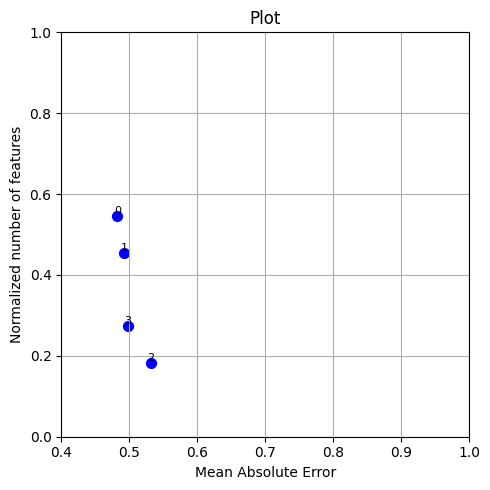


Iteration: 21/200


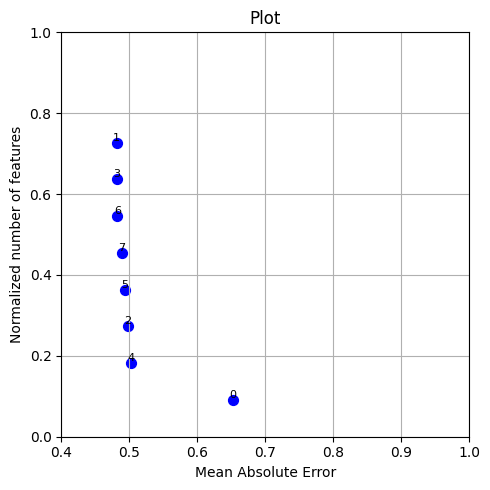


Iteration: 41/200


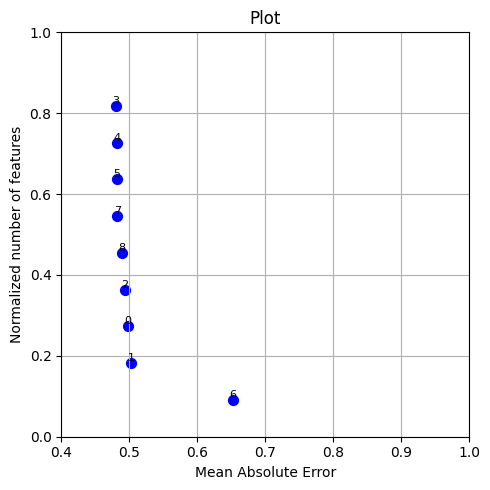


Iteration: 61/200


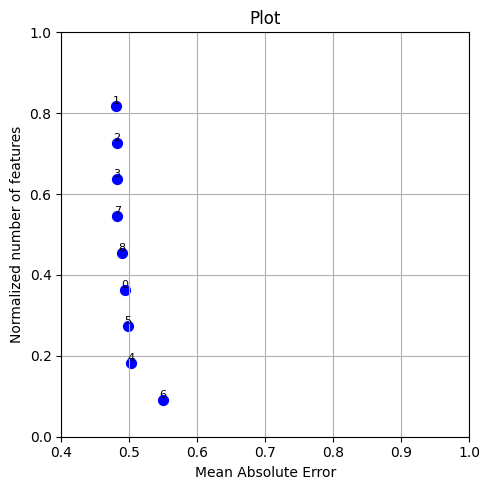


Iteration: 81/200


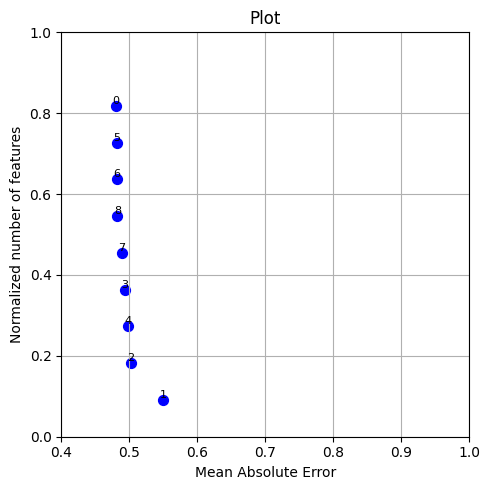


Iteration: 101/200


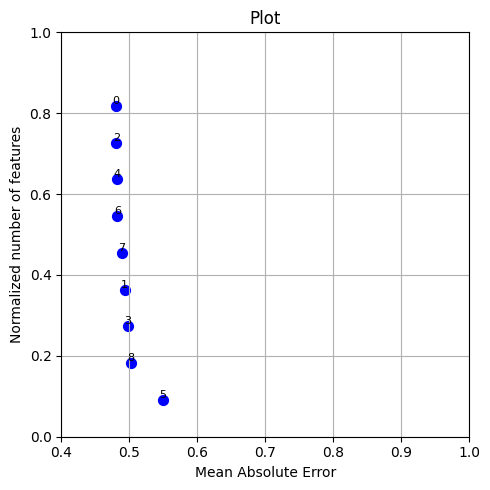


Iteration: 121/200


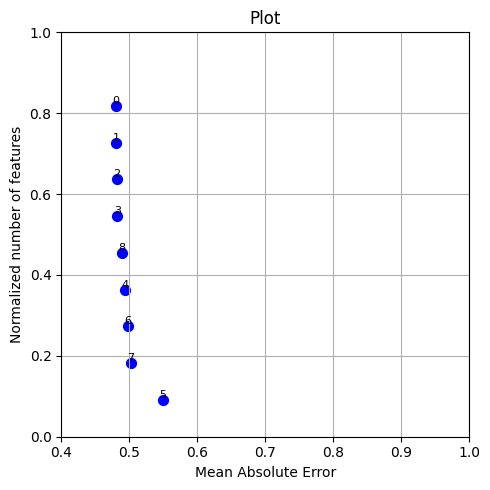


Iteration: 141/200


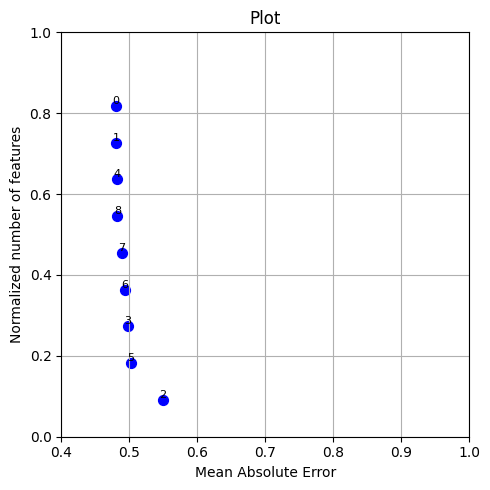


Iteration: 161/200


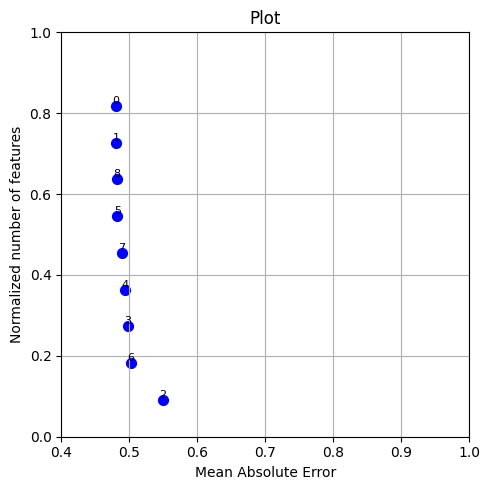


Iteration: 181/200


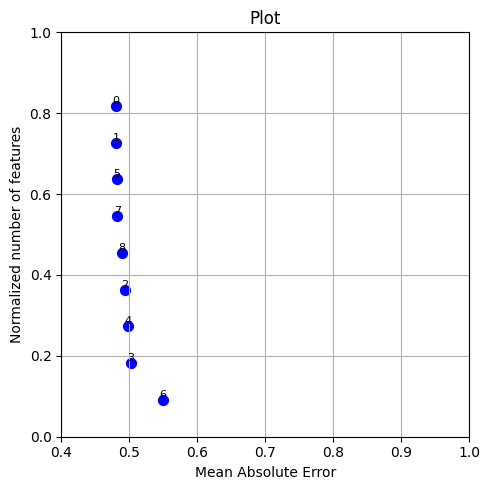


Iteration: 200/200


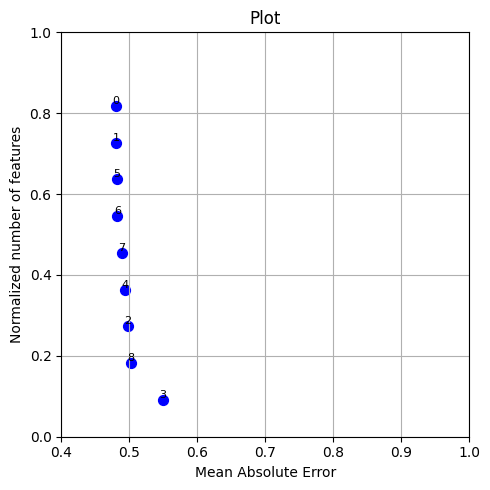

 Ok!


In [11]:
class EDA_solver:
	def __init__(self
		,problem:Problem
		,p_size:int       = 50
		,max_it:int       = 1000
		,split:float      = 0.5
		,rng              = None
		# Formatting options for progress bar
		,FEEDBACK_INT:int = 10
		,MAX_F_LEN:int    = 30
		,MAX_K_LEN:int    = 20
		,SPINNER:list[str]= ['\\', '|', '/', '-']
		,verbose:bool     = False
		,use_custom_print:bool= False
	):
		self.problem      = problem
		self.p_size       = p_size
		self.max_it       = max_it
		self.split        = split
		self.rng          = rng
		if rng is None:
			self.rng = np.random.default_rng()
		# Formatting options for progress bar
		self.FEEDBACK_INT = FEEDBACK_INT
		self.MAX_F_LEN    = MAX_F_LEN
		self.MAX_K_LEN    = MAX_K_LEN
		self.SPINNER      = SPINNER
		self.SPINNER_LEN  = len(self.SPINNER)
		self.verbose      = verbose
		self.use_custom_print= use_custom_print

		# solve() variables
		self.G       = None
		self.F       = None
		self.newG    = None
		self.newF    = None
		self.elite   = None
		self.Fe      = None
		self.dist    = None
		self.invalid = 0
		self.n_it    = 0
		self.converged:bool = False
	
	def _print_progress(self, n_k:int):
		if self.verbose:
			print(f'\nIteration: {n_k}/{self.max_it}')
			if self.use_custom_print:
				self.problem.custom_print(self.G, self.Fe)
			else:
				print(f'///Fitness///')
				print(np.array(self.F))
				print(f'///Elite///')
				print(np.array(self.Fe))
		else:
			spinner_idx:int = int(n_k/self.FEEDBACK_INT)%self.SPINNER_LEN
			k_percentage    = n_k/float(self.max_it)*100
			filled_k        = int(self.MAX_K_LEN *n_k // self.max_it)
			k_bar           = '#'*filled_k + '-'*(self.MAX_K_LEN - filled_k)
			
			print(f'\r{self.SPINNER[spinner_idx]}', end='')
			print(f' Iteration:[{k_bar}]{k_percentage:.2f}%', end=' ')

			if self.problem.has_progress_metric():
				progress = self.problem.get_progress_metric(self.Fe)
				filled_p = int(self.MAX_F_LEN * progress // self.problem.get_progress_max())
				p_bar = '#'*filled_p + '-'*(self.MAX_F_LEN - filled_p)
				variation = self.problem.get_variation(self.F)

				print(f'Fitness:[{p_bar}]pm {variation:.2f}', end='')
			#----------
	# end _print_progress

	def solve(self):
		self.G    = self.problem.generate_initial_population(self.p_size)
		self.newG = [None for i in range(self.p_size)]
		self.F    = self.problem.get_fitness(self.G)
		n_elites  = int(self.p_size * self.split)

		self.elite, self.Fe = self.problem.get_elite(self.G, self.F)

		for k in range(1, self.max_it +1):
			self.n_it = k
			if self.problem.solved(self.Fe):
				self._print_progress(k)
				self.converged = True
				break

			best = problem.arg_get_elite(self.G, self.F, n=n_elites)
			self.dist = problem.get_prob_dist(self.G[best])
			self.newG = problem.generate_from_prob_dist(self.dist, self.p_size)

			for i, g in enumerate(self.newG):
				if not problem.check_individual_integrity(g):
					self.newG[i] = self.G[i]

			Fi = self.problem.get_fitness(self.newG)

			elite_i   , Fe_i    = self.problem.get_elite(self.newG, Fi)
			self.elite, self.Fe = self.problem.update_elite(self.elite, elite_i, self.Fe, Fe_i)

			self.G = self.problem.deep_copy(self.newG)
			self.F = np.array(Fi)

			if k%self.FEEDBACK_INT == 1 or k==self.max_it:
				self._print_progress(k)
		#------------- end for
		print(' Ok!')
		return {
			 'success':  self.converged
			,'solution': self.elite
			,'prob dist':self.dist
			,'niter':    self.n_it
		}
	#---------- end solve

solver = EDA_solver(problem, max_it=200, FEEDBACK_INT=20, verbose=True, use_custom_print=True)
result = solver.solve()


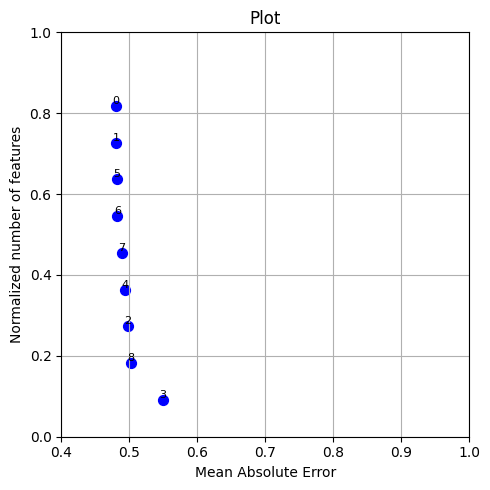

In [15]:
problem.custom_print(solver.elite, solver.Fe)

<BarContainer object of 11 artists>

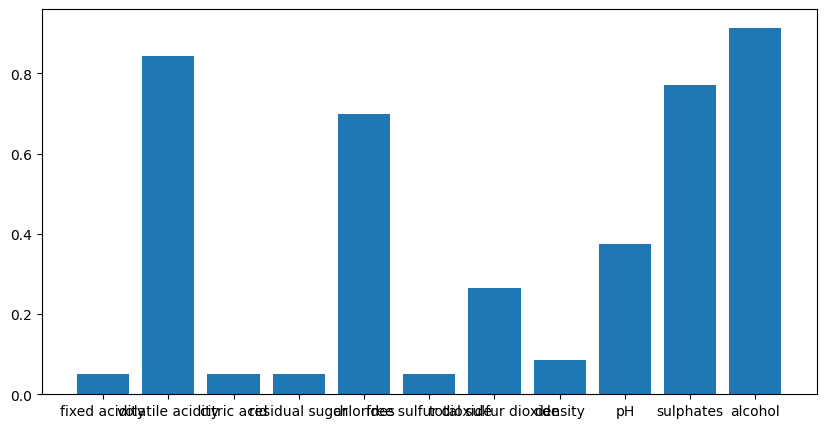

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(problem.features_names, result['prob dist'])

## Distribution Experiments

In [29]:
N_ROUNDS = 50

p_dists = np.zeros((N_ROUNDS, problem.num_features))

for i in range(N_ROUNDS):
	print(f'round {i+1} of {N_ROUNDS}')
	repeat = True
	round_solver = EDA_solver(problem, p_size=50, max_it=200, FEEDBACK_INT=5)
	while repeat:
		repeat = False
		try:
			solution = round_solver.solve()
		except:
			print('err!')
			repeat = True
	p_dists[i] = round_solver.dist


round 1 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.02 Ok!
round 2 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.04 Ok!
round 3 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.02 Ok!
round 4 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.03 Ok!
round 5 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.02 Ok!
round 6 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.03 Ok!
round 7 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.02 Ok!
round 8 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.02 Ok!
round 9 of 50
\ Iteration:[####################]100.00% Fitness:[##################------------]pm 0.02 Ok!
round 10 of 50
\ Iteration:[

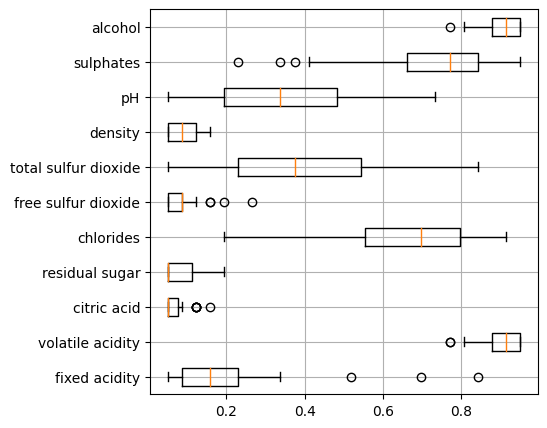

In [30]:
plt.figure(figsize=(5, 5))
plt.boxplot(p_dists, labels=problem.features_names, vert=False)
plt.grid(True)
plt.show()